In [4]:
import pandas as pd

# Load the tsv file
df = pd.read_csv('/Users/venkatasharatsripada/Downloads/deception_data_converted_final.tsv', 
                sep='\t')

# Examine the dataframe
print(df.shape)
print(df.describe())
df.head()

(92, 3)
       lie sentiment review
count   92        92     92
unique   2         2     91
top      t         n      ?
freq    46        46      2


,lie,sentiment,review
0,f,n,"'Mike\'s Pizza High Point, NY Service was very..."
1,f,n,'i really like this buffet restaurant in Marsh...
2,f,n,"'After I went shopping with some of my friend,..."
3,f,n,'Olive Oil Garden was very disappointing. I ex...
4,f,n,'The Seven Heaven restaurant was never known f...


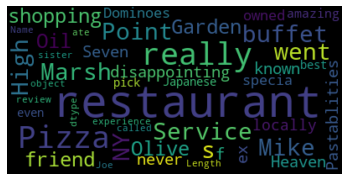

Word count before stop-words removal: 6971


In [2]:
# Let's see the initial word-cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re

def make_wordcloud(review):
    wordcloud = WordCloud().generate(review)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
make_wordcloud(str(df['review']))

# Gives us a fairly good idea that the reviews are based of restaurants. Also, see
# words like dissappointing & amazing which is reflective of mixed reviews.

# Step-1: Clean-out all the stop words in the review text
# Not too much in the wordcloud but to reduce feature-set during 
# vectorization, we will remove stopwords from text data. To quantify any 
# tangible benefits, we will record the word counts before vs after

def count_words(df):
    _len = 0
    for index in df.index:
        words = df['review'][index].split()
        _len += len(words)
    return _len

    
print('Word count before stop-words removal: %d' % count_words(df))

Word count after stop-words removal: 4176


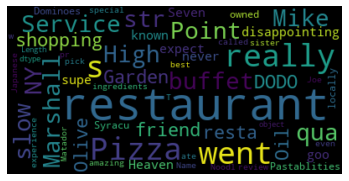

In [3]:
for index in df.index:
    words = df['review'][index].split()
    new_sent = ''
    for word in words:
        word = re.sub(',', '', word)
        if word in stopwords.words('english'):
            continue
        new_sent += ' ' + word
    df['review'][index] = new_sent

print('Word count after stop-words removal: %d' % count_words(df))

make_wordcloud(str(df['review']))

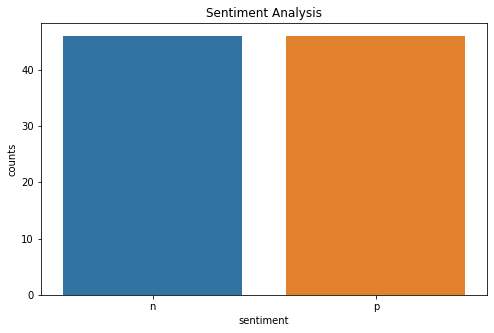

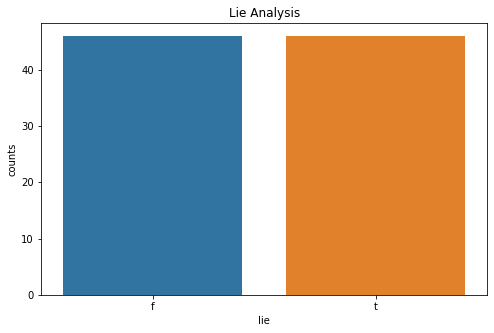

Fake and negative: 23
Fake and positive: 23
True and negative: 23
True and positive: 23


In [15]:
# Step-2: Let's see the overall sentiment and lie ratios
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bar_graph(title, label_groups, x):
    plt.figure(figsize=(8,5))
    ax = sns.barplot(x=x, y="counts", data=label_groups)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_title(label="%s" %title)
    plt.show()


_labels = df.groupby('sentiment').size().reset_index(name='counts')
plot_bar_graph('Sentiment Analysis', _labels, 'sentiment')


_labels = df.groupby('lie').size().reset_index(name='counts')
plot_bar_graph('Lie Analysis', _labels, 'lie')

# Also, curious to see any correlation between the lie & sentiment
# did this.
fake_and_neg = df.loc[(df['lie'] == 'f') & (df['sentiment'] == 'n')]
print('Fake and negative: %s' % fake_and_neg.shape[0])

fake_and_pos = df.loc[(df['lie'] == 'f') & (df['sentiment'] == 'p')]
print('Fake and positive: %s' % fake_and_pos.shape[0])

true_and_neg = df.loc[(df['lie'] == 't') & (df['sentiment'] == 'n')]
print('True and negative: %s' % true_and_neg.shape[0])

true_and_pos = df.loc[(df['lie'] == 't') & (df['sentiment'] == 'p')]
print('True and positive: %s' % true_and_pos.shape[0])

# Conclusion about data:
# - Plotting the sentiment, lie shows that the labels/classification
# is fairly balanced 
# - Also, the fake and truth about reviews seems is perfectly distributed
# between postive and negative sentiment.
# This data has been curated or collected for a very specific reason and 
# may not therefore a good data-set to train models. Likely, we can see 
# overfitting.

In [78]:
# Step-3: We will now make two data-sets:
# - lie labels
# - sentiment labels

df_lie = pd.DataFrame(columns=['lie', 'review'])
df_lie['lie'] = df['lie']
df_lie['review'] = df['review']

# Finally, shuffle the data to randomize it sufficiently to prevent
# overfitting
df_lie = df_lie.sample(frac=1).reset_index(drop=True)

df_lie.head()

,lie,review
0,f,'I entered restaurant waitress came blanking ...
1,f,'The Seven Heaven restaurant never known supe...
2,t,'Friday worse restaurant I ever gone. Each di...
3,t,'I went restaurant I ordered complimentary sa...
4,f,'In diner dish least one fly it. We waiting h...


In [79]:
df_sentiment = pd.DataFrame(columns=['sentiment', 'review'])
df_sentiment['sentiment'] = df['sentiment']
df_sentiment['review'] = df['review']

# Finally, shuffle the data to randomize it sufficiently to prevent
# overfitting

df_sentiment = df_sentiment.sample(frac=1).reset_index(drop=True)

df_sentiment.head()

,sentiment,review
0,n,'I went Chipotle Marshall Street dinner. The ...
1,n,'I don\'t usually write reviews TripAdvisor e...
2,p,'This Japanese restaurant popular recently Ja...
3,p,'I ate restaurant called Banana Leaf. As I en...
4,p,'The service good I felt like home. Waitresse...


In [92]:
# Since the data is mostly in terms of labels, we will normalize
# it using the vectorization method of TF-IDF.

# We will use the make_pipeline function. This will internally 
# transform the text data and then the model will be fitted using the transformed data.
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score


# Also, to prevent from overfitting we will use the k-folds methods
# to split the train, test data

from sklearn.model_selection import RepeatedKFold 
kf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=None)

X = df_lie.iloc[:, -1]
y = df_lie.iloc[:, 0]

# Build the model
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

_sum = 0

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model using the training data
    model.fit(X_train, y_train)
    
    # Predict the categories of the test data
    predicted_categories = model.predict(X_test)
    
    _sum += accuracy_score(y_test, predicted_categories)
    
# Print the summary based on n_splits - here 5
test_accuracy = _sum/100

print(test_accuracy)

0.4761111111111111


In [93]:
# Repeat this for the sentiment data
X = df_sentiment.iloc[:, -1]
y = df_sentiment.iloc[:, 0]

_sum = 0

for train_index, test_index in kf.split(X):
    
    X_train, X_test = X[train_index], X[test_index] 
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model using the training data
    model.fit(X_train, y_train)
    
    # Predict the categories of the test data
    predicted_categories = model.predict(X_test)
    
    _sum += accuracy_score(y_test, predicted_categories)
    
# Print the summary based on n_splits - here 5
test_accuracy = _sum/100

print(test_accuracy)

0.8074444444444434
